<div style="margin-bottom: 15px; padding: 15px; color: #31708f; background-color: #d9edf7; border: 1px solid #bce8f1; border-radius: 5px;">
    
<b><font size=+2>Enter your information below:</font></b></br></br>

  <b>(full) Name</b>: Vismaya Anand Bolbandi
  </br>
  <b>Student ID Number</b>:  862548529
  </br></br>
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

# Overview
In this assignment you will implement some classifiers to predict whether or not images of cats are "deepfakes", i.e., generated by AI. (I used SD 1.5, and down-sampled to match CIFAR-10, which we use for real images.)

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, scikit-learn (for cross validation utility and for baseline logistic regression), matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the parts marked `TODO` and print desired results. (In some cases, this just means getting the code to work so the TODO section prints the correct result.)

In [ ]:
import torch
# The following functions are discussed in week 5 demo
import torch.nn as nn  # neural net layers and activations
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset  # Super useful data utilities!

# We discussed all these in week 4 demo:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Used for visualization
import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Turn off some annoying convergence warnings from sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## **Obtain and inspect data [3 points]**
You can download the data file here:
 https://elearn.ucr.edu/courses/169673/files/17302822/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

<ipython-input-39-c3db27e095f2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X, y = torch.load('hw2_data.pt')


Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



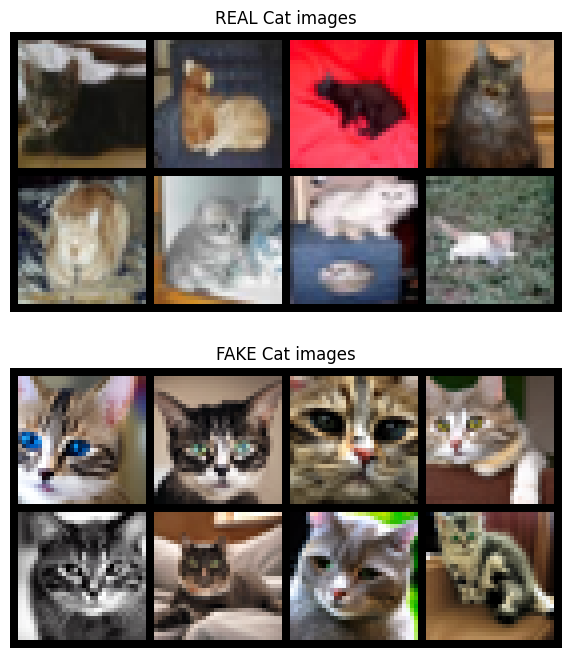

In [ ]:
# Load dataset and visualize
X, y = torch.load('hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Print examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))


X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import torch

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

val_accs = []  # Store validation accuracy for each fold
train_accs = []  # Store training accuracy for each fold

# Iterate over folds
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Fit logistic regression model on training data
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Compute and store accuracy on train data
    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_accs.append(train_acc)

    # Compute and store accuracy on validation data
    val_acc = accuracy_score(y_val, model.predict(X_val))
    val_accs.append(val_acc)

# Compute mean and standard deviation of accuracies
train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

# Standard error is standard deviation / sqrt(n_folds)
rootn = torch.sqrt(torch.tensor(n_folds))
print(f'Train Accuracy and standard error:\t {train_mean:.3f} +/- {train_std / rootn:.3f}')
print(f'Validation Accuracy and standard error:\t {val_mean:.3f} +/- {val_std / rootn:.3f}')

Train Accuracy and standard error:	 0.992 +/- 0.001
Validation Accuracy and standard error:	 0.633 +/- 0.011


## Define the model [3 points]

- As always, implement an __init__ function and a forward function
- Use Linear layers with ReLU activations for the hidden layers
- 2 layers of hidden units. First layer has 128 hidden units, second layer has 64 hidden units.
- Output represents *binary* logits (must have correct shape to do that!)

In [ ]:
import torch
import torch.nn as nn

class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()

        # Define the layers
        self.layer1 = nn.Linear(in_features=3*32*32, out_features=128)  # First hidden layer (128 units)
        self.layer2 = nn.Linear(in_features=128, out_features=64)  # Second hidden layer (64 units)
        self.output = nn.Linear(in_features=64, out_features=1)  # Output layer (binary classification)

        # Define the activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input to 1D vector (batch_size, 3*32*32)
        x = x.view(x.size(0), -1)  # Flatten the input image

        # Apply the first hidden layer and ReLU activation
        x = self.relu(self.layer1(x))

        # Apply the second hidden layer and ReLU activation
        x = self.relu(self.layer2(x))

        # Output layer (logits for binary classification)
        x = self.output(x)

        return x

## Train function [6 points]
Make a function to train your neural net, following week 5 example

In [ ]:
 import torch
import torch.nn as nn
import torch.optim as optim

def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (e.g., Adam or SGD) and "criterion" as the loss function.
    """
    for epoch in range(n_epochs):
        # Set the model to training mode
        model.train()

        # Training loop
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients

            # Forward pass: Compute predicted y by passing x to the model
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())  # Calculate the loss
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update the weights

            running_loss += loss.item()  # Accumulate loss

        # After each epoch, print the training loss (optional)
        print(f"Epoch [{epoch+1}/{n_epochs}], Training loss: {running_loss / len(train_loader):.4f}")

        if verbose:
            # Set the model to evaluation mode to prevent gradient calculation
            model.eval()

            # Validation loop (optional: check the performance on validation set)
            val_loss = 0.0
            correct_preds = 0
            total_preds = 0
            with torch.no_grad():  # No need to calculate gradients for validation
                for inputs, labels in val_loader:
                    # Forward pass: Compute predicted y by passing x to the model
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels.float())  # Calculate the loss
                    val_loss += loss.item()  # Accumulate validation loss

                    # Compute accuracy for the validation set
                    preds = torch.sigmoid(outputs).round()  # Get binary predictions
                    correct_preds += (preds.squeeze() == labels).sum().item()  # Count correct predictions
                    total_preds += labels.size(0)  # Total samples

            # Print validation loss and accuracy
            val_accuracy = correct_preds / total_preds
            print(f"Validation loss: {val_loss / len(val_loader):.4f}, Validation accuracy: {val_accuracy:.4f}")

            # Set the model back to training mode for the next epoch
            model.train()

    print("Training complete.")


Loop over hyper-parameters and do 5-fold cross-validation for each setting, saving the train and validation mean accuracy and standard error.

In [ ]:
import torch
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Assuming MyMLP model is defined
# train function as defined in the previous steps

# Define hyperparameters
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 100
n_folds = 5

results = []

for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # store validation accuracy for each fold
        train_accs = []  # store training accuracy for each fold

        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

        for train_index, val_index in kf.split(X):  # X and y should be defined
            # Split data into train and validation sets
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Create data loaders for training and validation sets
            train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
            val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model, criterion (CrossEntropyLoss), and optimizer (SGD)
            model = MyMLP()  # Using the previously defined MLP model
            criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

            # Train the model using the defined train function
            train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)

            # Evaluate the model on the training data
            model.eval()
            with torch.no_grad():
                # Training accuracy
                train_preds = model(torch.tensor(X_train, dtype=torch.float32))
                train_preds = torch.sigmoid(train_preds).round()  # Apply sigmoid and round to get binary predictions
                train_acc = accuracy_score(y_train, train_preds.numpy())
                train_accs.append(train_acc)

                # Validation accuracy
                val_preds = model(torch.tensor(X_val, dtype=torch.float32))
                val_preds = torch.sigmoid(val_preds).round()  # Apply sigmoid and round to get binary predictions
                val_acc = accuracy_score(y_val, val_preds.numpy())
                val_accs.append(val_acc)

        # For each hyper-parameter, calculate the mean and standard error of accuracy
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

        # Standard error is standard deviation / sqrt(n), it is more typical to report this
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn

        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))

# Display the results
for result in results:
    print(f"LR: {result[0]}, WD: {result[1]}, Train Mean: {result[2]:.4f}, Train SE: {result[3]:.4f}, "
          f"Val Mean: {result[4]:.4f}, Val SE: {result[5]:.4f}")


<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))


Epoch [1/100], Training loss: 0.6947
Epoch [2/100], Training loss: 0.6937
Epoch [3/100], Training loss: 0.6928
Epoch [4/100], Training loss: 0.6919
Epoch [5/100], Training loss: 0.6910
Epoch [6/100], Training loss: 0.6901
Epoch [7/100], Training loss: 0.6892
Epoch [8/100], Training loss: 0.6883
Epoch [9/100], Training loss: 0.6874
Epoch [10/100], Training loss: 0.6865
Epoch [11/100], Training loss: 0.6856
Epoch [12/100], Training loss: 0.6847
Epoch [13/100], Training loss: 0.6838
Epoch [14/100], Training loss: 0.6829
Epoch [15/100], Training loss: 0.6821
Epoch [16/100], Training loss: 0.6812
Epoch [17/100], Training loss: 0.6803
Epoch [18/100], Training loss: 0.6794
Epoch [19/100], Training loss: 0.6786
Epoch [20/100], Training loss: 0.6777
Epoch [21/100], Training loss: 0.6768
Epoch [22/100], Training loss: 0.6759
Epoch [23/100], Training loss: 0.6751
Epoch [24/100], Training loss: 0.6742
Epoch [25/100], Training loss: 0.6732
Epoch [26/100], Training loss: 0.6723
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6924
Epoch [3/100], Training loss: 0.6912
Epoch [4/100], Training loss: 0.6900
Epoch [5/100], Training loss: 0.6887
Epoch [6/100], Training loss: 0.6875
Epoch [7/100], Training loss: 0.6863
Epoch [8/100], Training loss: 0.6851
Epoch [9/100], Training loss: 0.6838
Epoch [10/100], Training loss: 0.6826
Epoch [11/100], Training loss: 0.6814
Epoch [12/100], Training loss: 0.6801
Epoch [13/100], Training loss: 0.6789
Epoch [14/100], Training loss: 0.6776
Epoch [15/100], Training loss: 0.6764
Epoch [16/100], Training loss: 0.6752
Epoch [17/100], Training loss: 0.6740
Epoch [18/100], Training loss: 0.6727
Epoch [19/100], Training loss: 0.6715
Epoch [20/100], Training loss: 0.6702
Epoch [21/100], Training loss: 0.6690
Epoch [22/100], Training loss: 0.6677
Epoch [23/100], Training loss: 0.6665
Epoch [24/100], Training loss: 0.6652
Epoch [25/100], Training loss: 0.6639
Epoch [26/100], Training loss: 0.6627
Epoch [27/100], Training loss: 0.6614
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6944
Epoch [2/100], Training loss: 0.6930
Epoch [3/100], Training loss: 0.6917
Epoch [4/100], Training loss: 0.6905
Epoch [5/100], Training loss: 0.6893
Epoch [6/100], Training loss: 0.6881
Epoch [7/100], Training loss: 0.6870
Epoch [8/100], Training loss: 0.6859
Epoch [9/100], Training loss: 0.6848
Epoch [10/100], Training loss: 0.6838
Epoch [11/100], Training loss: 0.6828
Epoch [12/100], Training loss: 0.6818
Epoch [13/100], Training loss: 0.6808
Epoch [14/100], Training loss: 0.6797
Epoch [15/100], Training loss: 0.6787
Epoch [16/100], Training loss: 0.6777
Epoch [17/100], Training loss: 0.6767
Epoch [18/100], Training loss: 0.6757
Epoch [19/100], Training loss: 0.6746
Epoch [20/100], Training loss: 0.6736
Epoch [21/100], Training loss: 0.6725
Epoch [22/100], Training loss: 0.6715
Epoch [23/100], Training loss: 0.6704
Epoch [24/100], Training loss: 0.6693
Epoch [25/100], Training loss: 0.6682
Epoch [26/100], Training loss: 0.6670
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6923
Epoch [2/100], Training loss: 0.6915
Epoch [3/100], Training loss: 0.6908
Epoch [4/100], Training loss: 0.6901
Epoch [5/100], Training loss: 0.6894
Epoch [6/100], Training loss: 0.6887
Epoch [7/100], Training loss: 0.6881
Epoch [8/100], Training loss: 0.6874
Epoch [9/100], Training loss: 0.6868
Epoch [10/100], Training loss: 0.6862
Epoch [11/100], Training loss: 0.6856
Epoch [12/100], Training loss: 0.6850
Epoch [13/100], Training loss: 0.6844
Epoch [14/100], Training loss: 0.6838
Epoch [15/100], Training loss: 0.6832
Epoch [16/100], Training loss: 0.6826
Epoch [17/100], Training loss: 0.6820
Epoch [18/100], Training loss: 0.6814
Epoch [19/100], Training loss: 0.6808
Epoch [20/100], Training loss: 0.6802
Epoch [21/100], Training loss: 0.6796
Epoch [22/100], Training loss: 0.6789
Epoch [23/100], Training loss: 0.6783
Epoch [24/100], Training loss: 0.6777
Epoch [25/100], Training loss: 0.6770
Epoch [26/100], Training loss: 0.6764
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6978
Epoch [2/100], Training loss: 0.6967
Epoch [3/100], Training loss: 0.6956
Epoch [4/100], Training loss: 0.6946
Epoch [5/100], Training loss: 0.6936
Epoch [6/100], Training loss: 0.6927
Epoch [7/100], Training loss: 0.6917
Epoch [8/100], Training loss: 0.6908
Epoch [9/100], Training loss: 0.6898
Epoch [10/100], Training loss: 0.6889
Epoch [11/100], Training loss: 0.6880
Epoch [12/100], Training loss: 0.6871
Epoch [13/100], Training loss: 0.6862
Epoch [14/100], Training loss: 0.6853
Epoch [15/100], Training loss: 0.6844
Epoch [16/100], Training loss: 0.6836
Epoch [17/100], Training loss: 0.6827
Epoch [18/100], Training loss: 0.6818
Epoch [19/100], Training loss: 0.6809
Epoch [20/100], Training loss: 0.6800
Epoch [21/100], Training loss: 0.6791
Epoch [22/100], Training loss: 0.6782
Epoch [23/100], Training loss: 0.6773
Epoch [24/100], Training loss: 0.6764
Epoch [25/100], Training loss: 0.6754
Epoch [26/100], Training loss: 0.6745
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6974
Epoch [2/100], Training loss: 0.6962
Epoch [3/100], Training loss: 0.6951
Epoch [4/100], Training loss: 0.6939
Epoch [5/100], Training loss: 0.6928
Epoch [6/100], Training loss: 0.6918
Epoch [7/100], Training loss: 0.6907
Epoch [8/100], Training loss: 0.6897
Epoch [9/100], Training loss: 0.6887
Epoch [10/100], Training loss: 0.6877
Epoch [11/100], Training loss: 0.6868
Epoch [12/100], Training loss: 0.6858
Epoch [13/100], Training loss: 0.6848
Epoch [14/100], Training loss: 0.6839
Epoch [15/100], Training loss: 0.6829
Epoch [16/100], Training loss: 0.6820
Epoch [17/100], Training loss: 0.6810
Epoch [18/100], Training loss: 0.6800
Epoch [19/100], Training loss: 0.6791
Epoch [20/100], Training loss: 0.6781
Epoch [21/100], Training loss: 0.6771
Epoch [22/100], Training loss: 0.6761
Epoch [23/100], Training loss: 0.6751
Epoch [24/100], Training loss: 0.6741
Epoch [25/100], Training loss: 0.6731
Epoch [26/100], Training loss: 0.6721
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6933
Epoch [3/100], Training loss: 0.6924
Epoch [4/100], Training loss: 0.6915
Epoch [5/100], Training loss: 0.6905
Epoch [6/100], Training loss: 0.6896
Epoch [7/100], Training loss: 0.6887
Epoch [8/100], Training loss: 0.6878
Epoch [9/100], Training loss: 0.6869
Epoch [10/100], Training loss: 0.6860
Epoch [11/100], Training loss: 0.6851
Epoch [12/100], Training loss: 0.6842
Epoch [13/100], Training loss: 0.6834
Epoch [14/100], Training loss: 0.6825
Epoch [15/100], Training loss: 0.6817
Epoch [16/100], Training loss: 0.6808
Epoch [17/100], Training loss: 0.6799
Epoch [18/100], Training loss: 0.6791
Epoch [19/100], Training loss: 0.6782
Epoch [20/100], Training loss: 0.6774
Epoch [21/100], Training loss: 0.6765
Epoch [22/100], Training loss: 0.6757
Epoch [23/100], Training loss: 0.6749
Epoch [24/100], Training loss: 0.6740
Epoch [25/100], Training loss: 0.6732
Epoch [26/100], Training loss: 0.6723
Epoch [27/100], Training loss: 0.6715
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6939
Epoch [3/100], Training loss: 0.6931
Epoch [4/100], Training loss: 0.6924
Epoch [5/100], Training loss: 0.6917
Epoch [6/100], Training loss: 0.6910
Epoch [7/100], Training loss: 0.6903
Epoch [8/100], Training loss: 0.6897
Epoch [9/100], Training loss: 0.6890
Epoch [10/100], Training loss: 0.6883
Epoch [11/100], Training loss: 0.6877
Epoch [12/100], Training loss: 0.6870
Epoch [13/100], Training loss: 0.6863
Epoch [14/100], Training loss: 0.6857
Epoch [15/100], Training loss: 0.6850
Epoch [16/100], Training loss: 0.6844
Epoch [17/100], Training loss: 0.6837
Epoch [18/100], Training loss: 0.6831
Epoch [19/100], Training loss: 0.6824
Epoch [20/100], Training loss: 0.6817
Epoch [21/100], Training loss: 0.6810
Epoch [22/100], Training loss: 0.6804
Epoch [23/100], Training loss: 0.6797
Epoch [24/100], Training loss: 0.6790
Epoch [25/100], Training loss: 0.6783
Epoch [26/100], Training loss: 0.6776
Epoch [27/100], Training loss: 0.6768
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6905
Epoch [3/100], Training loss: 0.6895
Epoch [4/100], Training loss: 0.6885
Epoch [5/100], Training loss: 0.6875
Epoch [6/100], Training loss: 0.6865
Epoch [7/100], Training loss: 0.6855
Epoch [8/100], Training loss: 0.6845
Epoch [9/100], Training loss: 0.6835
Epoch [10/100], Training loss: 0.6825
Epoch [11/100], Training loss: 0.6815
Epoch [12/100], Training loss: 0.6804
Epoch [13/100], Training loss: 0.6794
Epoch [14/100], Training loss: 0.6783
Epoch [15/100], Training loss: 0.6773
Epoch [16/100], Training loss: 0.6762
Epoch [17/100], Training loss: 0.6751
Epoch [18/100], Training loss: 0.6741
Epoch [19/100], Training loss: 0.6730
Epoch [20/100], Training loss: 0.6719
Epoch [21/100], Training loss: 0.6708
Epoch [22/100], Training loss: 0.6697
Epoch [23/100], Training loss: 0.6686
Epoch [24/100], Training loss: 0.6675
Epoch [25/100], Training loss: 0.6664
Epoch [26/100], Training loss: 0.6653
Epoch [27/100], Training loss: 0.6641
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6922
Epoch [3/100], Training loss: 0.6911
Epoch [4/100], Training loss: 0.6900
Epoch [5/100], Training loss: 0.6889
Epoch [6/100], Training loss: 0.6878
Epoch [7/100], Training loss: 0.6868
Epoch [8/100], Training loss: 0.6858
Epoch [9/100], Training loss: 0.6848
Epoch [10/100], Training loss: 0.6838
Epoch [11/100], Training loss: 0.6828
Epoch [12/100], Training loss: 0.6818
Epoch [13/100], Training loss: 0.6808
Epoch [14/100], Training loss: 0.6799
Epoch [15/100], Training loss: 0.6789
Epoch [16/100], Training loss: 0.6779
Epoch [17/100], Training loss: 0.6769
Epoch [18/100], Training loss: 0.6759
Epoch [19/100], Training loss: 0.6749
Epoch [20/100], Training loss: 0.6739
Epoch [21/100], Training loss: 0.6729
Epoch [22/100], Training loss: 0.6718
Epoch [23/100], Training loss: 0.6708
Epoch [24/100], Training loss: 0.6698
Epoch [25/100], Training loss: 0.6688
Epoch [26/100], Training loss: 0.6677
Epoch [27/100], Training loss: 0.6666
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6756
Epoch [3/100], Training loss: 0.6635
Epoch [4/100], Training loss: 0.6510
Epoch [5/100], Training loss: 0.6374
Epoch [6/100], Training loss: 0.6221
Epoch [7/100], Training loss: 0.6057
Epoch [8/100], Training loss: 0.5876
Epoch [9/100], Training loss: 0.5686
Epoch [10/100], Training loss: 0.5490
Epoch [11/100], Training loss: 0.5297
Epoch [12/100], Training loss: 0.5105
Epoch [13/100], Training loss: 0.4921
Epoch [14/100], Training loss: 0.4749
Epoch [15/100], Training loss: 0.4580
Epoch [16/100], Training loss: 0.4420
Epoch [17/100], Training loss: 0.4266
Epoch [18/100], Training loss: 0.4121
Epoch [19/100], Training loss: 0.3988
Epoch [20/100], Training loss: 0.3851
Epoch [21/100], Training loss: 0.3728
Epoch [22/100], Training loss: 0.3602
Epoch [23/100], Training loss: 0.3464
Epoch [24/100], Training loss: 0.3383
Epoch [25/100], Training loss: 0.3253
Epoch [26/100], Training loss: 0.3136
Epoch [27/100], Training loss: 0.3030
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6919
Epoch [2/100], Training loss: 0.6828
Epoch [3/100], Training loss: 0.6732
Epoch [4/100], Training loss: 0.6629
Epoch [5/100], Training loss: 0.6518
Epoch [6/100], Training loss: 0.6397
Epoch [7/100], Training loss: 0.6264
Epoch [8/100], Training loss: 0.6124
Epoch [9/100], Training loss: 0.5976
Epoch [10/100], Training loss: 0.5823
Epoch [11/100], Training loss: 0.5666
Epoch [12/100], Training loss: 0.5510
Epoch [13/100], Training loss: 0.5351
Epoch [14/100], Training loss: 0.5196
Epoch [15/100], Training loss: 0.5040
Epoch [16/100], Training loss: 0.4892
Epoch [17/100], Training loss: 0.4744
Epoch [18/100], Training loss: 0.4606
Epoch [19/100], Training loss: 0.4471
Epoch [20/100], Training loss: 0.4335
Epoch [21/100], Training loss: 0.4205
Epoch [22/100], Training loss: 0.4081
Epoch [23/100], Training loss: 0.3961
Epoch [24/100], Training loss: 0.3832
Epoch [25/100], Training loss: 0.3728
Epoch [26/100], Training loss: 0.3614
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6873
Epoch [2/100], Training loss: 0.6760
Epoch [3/100], Training loss: 0.6644
Epoch [4/100], Training loss: 0.6518
Epoch [5/100], Training loss: 0.6373
Epoch [6/100], Training loss: 0.6212
Epoch [7/100], Training loss: 0.6036
Epoch [8/100], Training loss: 0.5850
Epoch [9/100], Training loss: 0.5663
Epoch [10/100], Training loss: 0.5472
Epoch [11/100], Training loss: 0.5288
Epoch [12/100], Training loss: 0.5112
Epoch [13/100], Training loss: 0.4941
Epoch [14/100], Training loss: 0.4779
Epoch [15/100], Training loss: 0.4627
Epoch [16/100], Training loss: 0.4486
Epoch [17/100], Training loss: 0.4349
Epoch [18/100], Training loss: 0.4202
Epoch [19/100], Training loss: 0.4078
Epoch [20/100], Training loss: 0.3947
Epoch [21/100], Training loss: 0.3827
Epoch [22/100], Training loss: 0.3703
Epoch [23/100], Training loss: 0.3593
Epoch [24/100], Training loss: 0.3476
Epoch [25/100], Training loss: 0.3368
Epoch [26/100], Training loss: 0.3261
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6921
Epoch [2/100], Training loss: 0.6828
Epoch [3/100], Training loss: 0.6733
Epoch [4/100], Training loss: 0.6625
Epoch [5/100], Training loss: 0.6498
Epoch [6/100], Training loss: 0.6352
Epoch [7/100], Training loss: 0.6185
Epoch [8/100], Training loss: 0.5999
Epoch [9/100], Training loss: 0.5805
Epoch [10/100], Training loss: 0.5603
Epoch [11/100], Training loss: 0.5400
Epoch [12/100], Training loss: 0.5206
Epoch [13/100], Training loss: 0.5025
Epoch [14/100], Training loss: 0.4846
Epoch [15/100], Training loss: 0.4688
Epoch [16/100], Training loss: 0.4529
Epoch [17/100], Training loss: 0.4371
Epoch [18/100], Training loss: 0.4230
Epoch [19/100], Training loss: 0.4089
Epoch [20/100], Training loss: 0.3952
Epoch [21/100], Training loss: 0.3835
Epoch [22/100], Training loss: 0.3704
Epoch [23/100], Training loss: 0.3581
Epoch [24/100], Training loss: 0.3468
Epoch [25/100], Training loss: 0.3368
Epoch [26/100], Training loss: 0.3250
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6928
Epoch [2/100], Training loss: 0.6839
Epoch [3/100], Training loss: 0.6743
Epoch [4/100], Training loss: 0.6637
Epoch [5/100], Training loss: 0.6519
Epoch [6/100], Training loss: 0.6386
Epoch [7/100], Training loss: 0.6242
Epoch [8/100], Training loss: 0.6088
Epoch [9/100], Training loss: 0.5931
Epoch [10/100], Training loss: 0.5771
Epoch [11/100], Training loss: 0.5611
Epoch [12/100], Training loss: 0.5454
Epoch [13/100], Training loss: 0.5297
Epoch [14/100], Training loss: 0.5144
Epoch [15/100], Training loss: 0.4992
Epoch [16/100], Training loss: 0.4845
Epoch [17/100], Training loss: 0.4700
Epoch [18/100], Training loss: 0.4563
Epoch [19/100], Training loss: 0.4432
Epoch [20/100], Training loss: 0.4302
Epoch [21/100], Training loss: 0.4182
Epoch [22/100], Training loss: 0.4064
Epoch [23/100], Training loss: 0.3933
Epoch [24/100], Training loss: 0.3826
Epoch [25/100], Training loss: 0.3714
Epoch [26/100], Training loss: 0.3606
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6809
Epoch [3/100], Training loss: 0.6721
Epoch [4/100], Training loss: 0.6621
Epoch [5/100], Training loss: 0.6507
Epoch [6/100], Training loss: 0.6381
Epoch [7/100], Training loss: 0.6245
Epoch [8/100], Training loss: 0.6100
Epoch [9/100], Training loss: 0.5952
Epoch [10/100], Training loss: 0.5803
Epoch [11/100], Training loss: 0.5652
Epoch [12/100], Training loss: 0.5502
Epoch [13/100], Training loss: 0.5348
Epoch [14/100], Training loss: 0.5198
Epoch [15/100], Training loss: 0.5047
Epoch [16/100], Training loss: 0.4899
Epoch [17/100], Training loss: 0.4755
Epoch [18/100], Training loss: 0.4619
Epoch [19/100], Training loss: 0.4478
Epoch [20/100], Training loss: 0.4348
Epoch [21/100], Training loss: 0.4223
Epoch [22/100], Training loss: 0.4101
Epoch [23/100], Training loss: 0.3984
Epoch [24/100], Training loss: 0.3868
Epoch [25/100], Training loss: 0.3769
Epoch [26/100], Training loss: 0.3652
Epoch [27/100], Training loss: 0.3554
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6854
Epoch [3/100], Training loss: 0.6792
Epoch [4/100], Training loss: 0.6725
Epoch [5/100], Training loss: 0.6651
Epoch [6/100], Training loss: 0.6570
Epoch [7/100], Training loss: 0.6481
Epoch [8/100], Training loss: 0.6380
Epoch [9/100], Training loss: 0.6267
Epoch [10/100], Training loss: 0.6142
Epoch [11/100], Training loss: 0.6007
Epoch [12/100], Training loss: 0.5866
Epoch [13/100], Training loss: 0.5720
Epoch [14/100], Training loss: 0.5568
Epoch [15/100], Training loss: 0.5422
Epoch [16/100], Training loss: 0.5279
Epoch [17/100], Training loss: 0.5133
Epoch [18/100], Training loss: 0.4995
Epoch [19/100], Training loss: 0.4859
Epoch [20/100], Training loss: 0.4733
Epoch [21/100], Training loss: 0.4607
Epoch [22/100], Training loss: 0.4484
Epoch [23/100], Training loss: 0.4368
Epoch [24/100], Training loss: 0.4254
Epoch [25/100], Training loss: 0.4137
Epoch [26/100], Training loss: 0.4029
Epoch [27/100], Training loss: 0.3923
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6818
Epoch [3/100], Training loss: 0.6723
Epoch [4/100], Training loss: 0.6613
Epoch [5/100], Training loss: 0.6487
Epoch [6/100], Training loss: 0.6341
Epoch [7/100], Training loss: 0.6184
Epoch [8/100], Training loss: 0.6019
Epoch [9/100], Training loss: 0.5849
Epoch [10/100], Training loss: 0.5677
Epoch [11/100], Training loss: 0.5508
Epoch [12/100], Training loss: 0.5341
Epoch [13/100], Training loss: 0.5178
Epoch [14/100], Training loss: 0.5022
Epoch [15/100], Training loss: 0.4866
Epoch [16/100], Training loss: 0.4718
Epoch [17/100], Training loss: 0.4576
Epoch [18/100], Training loss: 0.4439
Epoch [19/100], Training loss: 0.4303
Epoch [20/100], Training loss: 0.4174
Epoch [21/100], Training loss: 0.4047
Epoch [22/100], Training loss: 0.3929
Epoch [23/100], Training loss: 0.3813
Epoch [24/100], Training loss: 0.3699
Epoch [25/100], Training loss: 0.3582
Epoch [26/100], Training loss: 0.3473
Epoch [27/100], Training loss: 0.3370
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6845
Epoch [3/100], Training loss: 0.6765
Epoch [4/100], Training loss: 0.6677
Epoch [5/100], Training loss: 0.6578
Epoch [6/100], Training loss: 0.6468
Epoch [7/100], Training loss: 0.6347
Epoch [8/100], Training loss: 0.6218
Epoch [9/100], Training loss: 0.6081
Epoch [10/100], Training loss: 0.5937
Epoch [11/100], Training loss: 0.5789
Epoch [12/100], Training loss: 0.5635
Epoch [13/100], Training loss: 0.5480
Epoch [14/100], Training loss: 0.5324
Epoch [15/100], Training loss: 0.5164
Epoch [16/100], Training loss: 0.5003
Epoch [17/100], Training loss: 0.4847
Epoch [18/100], Training loss: 0.4695
Epoch [19/100], Training loss: 0.4549
Epoch [20/100], Training loss: 0.4409
Epoch [21/100], Training loss: 0.4276
Epoch [22/100], Training loss: 0.4143
Epoch [23/100], Training loss: 0.4022
Epoch [24/100], Training loss: 0.3894
Epoch [25/100], Training loss: 0.3779
Epoch [26/100], Training loss: 0.3665
Epoch [27/100], Training loss: 0.3555
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.6873
Epoch [3/100], Training loss: 0.6788
Epoch [4/100], Training loss: 0.6697
Epoch [5/100], Training loss: 0.6595
Epoch [6/100], Training loss: 0.6481
Epoch [7/100], Training loss: 0.6356
Epoch [8/100], Training loss: 0.6219
Epoch [9/100], Training loss: 0.6075
Epoch [10/100], Training loss: 0.5928
Epoch [11/100], Training loss: 0.5779
Epoch [12/100], Training loss: 0.5629
Epoch [13/100], Training loss: 0.5480
Epoch [14/100], Training loss: 0.5332
Epoch [15/100], Training loss: 0.5192
Epoch [16/100], Training loss: 0.5051
Epoch [17/100], Training loss: 0.4908
Epoch [18/100], Training loss: 0.4781
Epoch [19/100], Training loss: 0.4650
Epoch [20/100], Training loss: 0.4533
Epoch [21/100], Training loss: 0.4412
Epoch [22/100], Training loss: 0.4301
Epoch [23/100], Training loss: 0.4186
Epoch [24/100], Training loss: 0.4081
Epoch [25/100], Training loss: 0.3974
Epoch [26/100], Training loss: 0.3880
Epoch [27/100], Training loss: 0.3779
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [2/100], Training loss: 0.4990
Epoch [3/100], Training loss: 0.3922
Epoch [4/100], Training loss: 0.3169
Epoch [5/100], Training loss: 0.2717
Epoch [6/100], Training loss: 0.1991
Epoch [7/100], Training loss: 0.1620
Epoch [8/100], Training loss: 0.1151
Epoch [9/100], Training loss: 0.0824
Epoch [10/100], Training loss: 0.0814
Epoch [11/100], Training loss: 0.0467
Epoch [12/100], Training loss: 0.0323
Epoch [13/100], Training loss: 0.0280
Epoch [14/100], Training loss: 0.0210
Epoch [15/100], Training loss: 0.0202
Epoch [16/100], Training loss: 0.0163
Epoch [17/100], Training loss: 0.0150
Epoch [18/100], Training loss: 0.0115
Epoch [19/100], Training loss: 0.0118
Epoch [20/100], Training loss: 0.0101
Epoch [21/100], Training loss: 0.0101
Epoch [22/100], Training loss: 0.0084
Epoch [23/100], Training loss: 0.0073
Epoch [24/100], Training loss: 0.0060
Epoch [25/100], Training loss: 0.0051
Epoch [26/100], Training loss: 0.0056
Epoch [27/100], Training loss: 0.0039
Epoch [28/100], Trai

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6441
Epoch [2/100], Training loss: 0.5225
Epoch [3/100], Training loss: 0.4248
Epoch [4/100], Training loss: 0.3521
Epoch [5/100], Training loss: 0.3088
Epoch [6/100], Training loss: 0.2364
Epoch [7/100], Training loss: 0.1890
Epoch [8/100], Training loss: 0.1496
Epoch [9/100], Training loss: 0.1373
Epoch [10/100], Training loss: 0.0896
Epoch [11/100], Training loss: 0.0710
Epoch [12/100], Training loss: 0.0599
Epoch [13/100], Training loss: 0.0332
Epoch [14/100], Training loss: 0.0243
Epoch [15/100], Training loss: 0.0300
Epoch [16/100], Training loss: 0.0225
Epoch [17/100], Training loss: 0.0132
Epoch [18/100], Training loss: 0.0121
Epoch [19/100], Training loss: 0.0149
Epoch [20/100], Training loss: 0.0125
Epoch [21/100], Training loss: 0.0081
Epoch [22/100], Training loss: 0.0046
Epoch [23/100], Training loss: 0.0136
Epoch [24/100], Training loss: 0.0103
Epoch [25/100], Training loss: 0.0067
Epoch [26/100], Training loss: 0.0062
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6482
Epoch [2/100], Training loss: 0.5161
Epoch [3/100], Training loss: 0.4128
Epoch [4/100], Training loss: 0.3443
Epoch [5/100], Training loss: 0.2869
Epoch [6/100], Training loss: 0.2344
Epoch [7/100], Training loss: 0.2044
Epoch [8/100], Training loss: 0.1455
Epoch [9/100], Training loss: 0.1139
Epoch [10/100], Training loss: 0.0919
Epoch [11/100], Training loss: 0.0645
Epoch [12/100], Training loss: 0.0405
Epoch [13/100], Training loss: 0.0409
Epoch [14/100], Training loss: 0.0259
Epoch [15/100], Training loss: 0.0205
Epoch [16/100], Training loss: 0.0186
Epoch [17/100], Training loss: 0.0158
Epoch [18/100], Training loss: 0.0135
Epoch [19/100], Training loss: 0.0117
Epoch [20/100], Training loss: 0.0105
Epoch [21/100], Training loss: 0.0085
Epoch [22/100], Training loss: 0.0097
Epoch [23/100], Training loss: 0.0073
Epoch [24/100], Training loss: 0.0066
Epoch [25/100], Training loss: 0.0063
Epoch [26/100], Training loss: 0.0038
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6497
Epoch [2/100], Training loss: 0.5260
Epoch [3/100], Training loss: 0.4328
Epoch [4/100], Training loss: 0.3503
Epoch [5/100], Training loss: 0.3036
Epoch [6/100], Training loss: 0.2561
Epoch [7/100], Training loss: 0.2017
Epoch [8/100], Training loss: 0.1909
Epoch [9/100], Training loss: 0.1239
Epoch [10/100], Training loss: 0.0936
Epoch [11/100], Training loss: 0.1291
Epoch [12/100], Training loss: 0.0792
Epoch [13/100], Training loss: 0.0449
Epoch [14/100], Training loss: 0.0300
Epoch [15/100], Training loss: 0.0249
Epoch [16/100], Training loss: 0.0218
Epoch [17/100], Training loss: 0.0157
Epoch [18/100], Training loss: 0.0172
Epoch [19/100], Training loss: 0.0167
Epoch [20/100], Training loss: 0.0151
Epoch [21/100], Training loss: 0.0106
Epoch [22/100], Training loss: 0.0091
Epoch [23/100], Training loss: 0.0081
Epoch [24/100], Training loss: 0.0073
Epoch [25/100], Training loss: 0.0050
Epoch [26/100], Training loss: 0.0048
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6483
Epoch [2/100], Training loss: 0.5141
Epoch [3/100], Training loss: 0.4127
Epoch [4/100], Training loss: 0.3358
Epoch [5/100], Training loss: 0.2957
Epoch [6/100], Training loss: 0.2260
Epoch [7/100], Training loss: 0.1828
Epoch [8/100], Training loss: 0.1529
Epoch [9/100], Training loss: 0.1198
Epoch [10/100], Training loss: 0.0762
Epoch [11/100], Training loss: 0.0536
Epoch [12/100], Training loss: 0.0444
Epoch [13/100], Training loss: 0.0343
Epoch [14/100], Training loss: 0.0209
Epoch [15/100], Training loss: 0.0210
Epoch [16/100], Training loss: 0.0206
Epoch [17/100], Training loss: 0.0150
Epoch [18/100], Training loss: 0.0122
Epoch [19/100], Training loss: 0.0127
Epoch [20/100], Training loss: 0.0089
Epoch [21/100], Training loss: 0.0156
Epoch [22/100], Training loss: 0.0109
Epoch [23/100], Training loss: 0.0071
Epoch [24/100], Training loss: 0.0092
Epoch [25/100], Training loss: 0.0057
Epoch [26/100], Training loss: 0.0054
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6522
Epoch [2/100], Training loss: 0.5300
Epoch [3/100], Training loss: 0.4272
Epoch [4/100], Training loss: 0.3533
Epoch [5/100], Training loss: 0.2976
Epoch [6/100], Training loss: 0.2520
Epoch [7/100], Training loss: 0.2152
Epoch [8/100], Training loss: 0.1634
Epoch [9/100], Training loss: 0.1436
Epoch [10/100], Training loss: 0.1327
Epoch [11/100], Training loss: 0.0987
Epoch [12/100], Training loss: 0.0714
Epoch [13/100], Training loss: 0.0783
Epoch [14/100], Training loss: 0.0462
Epoch [15/100], Training loss: 0.0437
Epoch [16/100], Training loss: 0.0361
Epoch [17/100], Training loss: 0.0343
Epoch [18/100], Training loss: 0.0320
Epoch [19/100], Training loss: 0.0288
Epoch [20/100], Training loss: 0.0299
Epoch [21/100], Training loss: 0.0272
Epoch [22/100], Training loss: 0.0303
Epoch [23/100], Training loss: 0.0301
Epoch [24/100], Training loss: 0.0264
Epoch [25/100], Training loss: 0.0252
Epoch [26/100], Training loss: 0.0235
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6552
Epoch [2/100], Training loss: 0.5344
Epoch [3/100], Training loss: 0.4424
Epoch [4/100], Training loss: 0.3768
Epoch [5/100], Training loss: 0.3233
Epoch [6/100], Training loss: 0.2816
Epoch [7/100], Training loss: 0.2359
Epoch [8/100], Training loss: 0.1997
Epoch [9/100], Training loss: 0.1757
Epoch [10/100], Training loss: 0.1282
Epoch [11/100], Training loss: 0.1137
Epoch [12/100], Training loss: 0.0896
Epoch [13/100], Training loss: 0.0840
Epoch [14/100], Training loss: 0.0578
Epoch [15/100], Training loss: 0.1957
Epoch [16/100], Training loss: 0.0528
Epoch [17/100], Training loss: 0.0398
Epoch [18/100], Training loss: 0.0330
Epoch [19/100], Training loss: 0.0327
Epoch [20/100], Training loss: 0.0286
Epoch [21/100], Training loss: 0.0288
Epoch [22/100], Training loss: 0.0277
Epoch [23/100], Training loss: 0.0234
Epoch [24/100], Training loss: 0.0242
Epoch [25/100], Training loss: 0.0230
Epoch [26/100], Training loss: 0.0243
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6641
Epoch [2/100], Training loss: 0.5506
Epoch [3/100], Training loss: 0.4410
Epoch [4/100], Training loss: 0.3642
Epoch [5/100], Training loss: 0.3069
Epoch [6/100], Training loss: 0.2655
Epoch [7/100], Training loss: 0.2212
Epoch [8/100], Training loss: 0.2049
Epoch [9/100], Training loss: 0.1598
Epoch [10/100], Training loss: 0.1100
Epoch [11/100], Training loss: 0.1127
Epoch [12/100], Training loss: 0.0726
Epoch [13/100], Training loss: 0.0585
Epoch [14/100], Training loss: 0.0546
Epoch [15/100], Training loss: 0.0556
Epoch [16/100], Training loss: 0.0509
Epoch [17/100], Training loss: 0.0365
Epoch [18/100], Training loss: 0.0384
Epoch [19/100], Training loss: 0.0335
Epoch [20/100], Training loss: 0.0312
Epoch [21/100], Training loss: 0.0287
Epoch [22/100], Training loss: 0.0253
Epoch [23/100], Training loss: 0.0280
Epoch [24/100], Training loss: 0.0244
Epoch [25/100], Training loss: 0.0267
Epoch [26/100], Training loss: 0.0282
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6592
Epoch [2/100], Training loss: 0.5370
Epoch [3/100], Training loss: 0.4286
Epoch [4/100], Training loss: 0.3531
Epoch [5/100], Training loss: 0.3014
Epoch [6/100], Training loss: 0.2809
Epoch [7/100], Training loss: 0.2324
Epoch [8/100], Training loss: 0.1869
Epoch [9/100], Training loss: 0.1428
Epoch [10/100], Training loss: 0.1393
Epoch [11/100], Training loss: 0.1020
Epoch [12/100], Training loss: 0.0824
Epoch [13/100], Training loss: 0.0635
Epoch [14/100], Training loss: 0.0596
Epoch [15/100], Training loss: 0.0492
Epoch [16/100], Training loss: 0.0490
Epoch [17/100], Training loss: 0.0347
Epoch [18/100], Training loss: 0.0334
Epoch [19/100], Training loss: 0.0303
Epoch [20/100], Training loss: 0.2171
Epoch [21/100], Training loss: 0.0637
Epoch [22/100], Training loss: 0.0386
Epoch [23/100], Training loss: 0.0322
Epoch [24/100], Training loss: 0.0290
Epoch [25/100], Training loss: 0.0281
Epoch [26/100], Training loss: 0.0257
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
<ipython-input-43-08011d4dd45a>:33: UserWarning: To copy co

Epoch [1/100], Training loss: 0.6481
Epoch [2/100], Training loss: 0.5242
Epoch [3/100], Training loss: 0.4293
Epoch [4/100], Training loss: 0.3625
Epoch [5/100], Training loss: 0.2998
Epoch [6/100], Training loss: 0.2432
Epoch [7/100], Training loss: 0.2349
Epoch [8/100], Training loss: 0.1759
Epoch [9/100], Training loss: 0.1411
Epoch [10/100], Training loss: 0.1384
Epoch [11/100], Training loss: 0.0885
Epoch [12/100], Training loss: 0.0725
Epoch [13/100], Training loss: 0.0661
Epoch [14/100], Training loss: 0.0541
Epoch [15/100], Training loss: 0.0414
Epoch [16/100], Training loss: 0.0416
Epoch [17/100], Training loss: 0.0340
Epoch [18/100], Training loss: 0.0311
Epoch [19/100], Training loss: 0.0326
Epoch [20/100], Training loss: 0.0357
Epoch [21/100], Training loss: 0.0303
Epoch [22/100], Training loss: 0.0279
Epoch [23/100], Training loss: 0.0292
Epoch [24/100], Training loss: 0.0323
Epoch [25/100], Training loss: 0.0264
Epoch [26/100], Training loss: 0.0256
Epoch [27/100], Train

<ipython-input-43-08011d4dd45a>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_preds = model(torch.tensor(X_train, dtype=torch.float32))
<ipython-input-43-08011d4dd45a>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_preds = model(torch.tensor(X_val, dtype=torch.float32))


## Show result [3 points]

In [ ]:
import pandas as pd

# Assuming 'results' contains the results from the previous cross-validation code
# Example: results = [(0.001, 0.0, 0.95, 0.02, 0.82, 0.05), ...]

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

# Print the training results
print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

# Print the validation results
print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.782 +/- 0.003,0.998 +/- 0.000,1.000 +/- 0.000
0.01,0.786 +/- 0.004,0.998 +/- 0.000,0.995 +/- 0.003


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.738 +/- 0.012,0.805 +/- 0.007,0.817 +/- 0.007
0.01,0.751 +/- 0.003,0.809 +/- 0.013,0.823 +/- 0.003


### Exporting the Notebook to PDF
To generate a nice looking PDF of your completed notebook, either use "Print" as PDF from Google colab (using Chrome), or if you are running locally, run the following command in the last cell:
```python
!jupyter nbconvert --to pdf --output=yourname_submission.pdf hw1.ipynb
```

## Extra credit

There are some nice opportunities for extra credit, though I will be fairly stingy with the points, so you should only try it if you're interested in learning more.
Some examples of things you could try for 1 extra point (and if you do multiple there will be a maximum of 2 extra points).
- Use t-SNE or UMAP to visualize a 2-d embedding of all the points, and see if the real and fake images are separable in the 2-d space.
- Use a more complex vision backbone like a pretrained ResNet to first embed the images, then train your MLP. You'll have to be careful to transform the images before input into a ResNet, as they usually expect a specific resolution. You can use torchvision transforms library for this. Does this increase accuracy? I don't know, but I speculate it won't help much - these embeddings are trained for classification accuracy, so they have no reason to preserve differences that are useful for finding fakes.
- Train a more complex vision backbone, instead of using the MLP. Again, a ResNet or a small vision transformer would be interesting. I think this would be the most typical and effective approach.
- Being an expert at hyper-parameter tuning is a skill that will benefit you greatly. Try a more fancy way to do this, like https://docs.wandb.ai, and see how well you can do on this assigment if you also vary other hyper-parameters (architecture, n_epochs, maybe early stopping, more learning rate/weight decay settings, regularizers, etc.)

Of course you can train your deepfake detector on my fakes, but how well will it do on ones from some other system? This is the fundamental research question in that field - how to build robust detectors that will work well even on new image generators.